In [1]:
import os, pandas as pd, numpy as np
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from sod.evaluation.datasets import oneminutewindows

dataframe = oneminutewindows(os.path.join(os.getcwd(), '..', 'dataset', 'executions','results', 'oneminutewindows.hdf'),
                             normalize=True)

predictions = pd.read_hdf(os.path.join(os.getcwd(), '..', 'evaluation', 'executions', 'results', 'oneminutewindows.ocsvm.yaml',
                                      'OneClassSVM?features=psd@2sec,psd@5sec&gamma=50&kernel=rbf&nu=0.1&cache_size=1500.evalpredictions.hdf'))

print('predictions: %d' % len(predictions))
predictions['modified'] = predictions['modified'].astype('category')

Opening /Users/riccardo/work/gfz/projects/sources/python/sod/sod/dataset/executions/results/oneminutewindows.hdf

                                instances
ok                              1,003,203
outl. (wrong inv. file)             4,356
outl. (cha. resp. acc <-> vel)  1,181,439
outl. (gain X100 or X0.01)      1,003,203
outl. (gain X10 or X0.1)        1,003,203
outl. (gain X2 or X0.5)         1,003,203
total                           5,198,607

Normalizing numeric columns (floats only)
(only good instances - no outliers - taken into account)
                prenorm_min prenorm_max   min median   max      NAs ids outside[.5-99.5]%
psd@0.05sec       -3,076.53      -18.62  0.00   0.97  1.13    2,652                 8,302
psd@0.1sec        -3,076.53      -18.54  0.00   0.97  1.12        0                 8,291
psd@0.2sec        -3,076.53      -18.22  0.00   0.97  1.10        4                 8,325
psd@0.5sec        -3,076.53      -17.80  0.00   0.97  1.10       16                 8,402


FileNotFoundError: File /Users/riccardo/work/gfz/projects/sources/python/sod/sod/jupyter/../evaluation/executions/results/oneminutewindows.ocsvm.yaml/OneClassSVM?features=psd@2sec,psd@5sec&gamma=50&kernel=rbf&nu=0.1&cache_size=1500.evalpredictions.hdf does not exist

In [57]:
from sod.core.evaluation import CLASSES, is_outlier, is_out_wrong_inv, is_out_swap_acc_vel, is_out_gain_x10, \
    is_out_gain_x100, is_out_gain_x2

funcs = [lambda df: ~is_outlier(df), is_out_wrong_inv, is_out_swap_acc_vel, is_out_gain_x100, 
         is_out_gain_x10, is_out_gain_x2]

# print(predictions.sort_values(by=['id', 'outlier', 'modified']).iloc[:100,:])
s = predictions.groupby(['id', 'outlier', 'modified'])  #

s = pd.DataFrame(s['correctly_predicted'].agg(['sum', 'size']).reset_index())


s = s[(s['size'].mod(3) == 0) & ((s['size'] == 3) | (s['sum'].mod(3) == 0))]  # there might be duplicates (WHY??!!! there should NOT be)


print('\nNumber of correctly classified (columns) per class (row)\n')
data = []
index = []
columns = [3, 2, 1, 0]
for label, func in CLASSES.items():
    dfr_ = s[func(s)]
    data.append({c: np.true_divide((dfr_['sum'] == c).sum(), len(dfr_)) for c in columns})
    index.append(label)
#     print('%s: %d %d %d %d' % (label,
#                                (dfr_['correctly_predicted'] == 3).sum(),
#                                (dfr_['correctly_predicted'] == 2).sum(),
#                                (dfr_['correctly_predicted'] == 1).sum(),
#                                (dfr_['correctly_predicted'] == 0).sum()
#                           ))


print(pd.DataFrame(index=index, columns=columns, data=data).to_string())


# from sod.evaluation import is_outlier, is_out_wrong_inv, is_out_gain

# # there are some segments evaluated more than once
# for _, df in s:
#     if (len(df) != 3) and df['correctly_predicted'].sum() != 0 and df['correctly_predicted'].sum() != len(df):
#         continue
#         print('\nskipping %s' % str(df))
#     if len(df) != 3:
#         _df = df.iloc[0, :]
#         _df['correctly_predicted'] = np.min(df['correctly_predicted'].sum(), 3)
    
#         df['correctly_predicted'] = df['correctly_predicted'].sum()
#         dfrs.append(dfrs.loc[])
#         dfrs.append()
#         if df['correctly_predicted'].sum() == 0 or df['correctly_predicted'].sum() == 
#         print(df)
#         raise ValueError()

# s2 = s['correctly_predicted'].agg('sum')
# total = 0
# for res in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
#     zum = (s2==res).sum()
#     total += zum
#     print('correctly_predicted==%d: %d segments' % (res, zum))

# print('total: %d' % total)    
# s==1
# predictions.columns


Number of correctly classified (columns) per class (row)

                                       3         2         1         0
ok                              0.840691  0.064960  0.048165  0.046183
outl. (wrong inv. file)         0.995169  0.000690  0.004141  0.000000
outl. (cha. resp. acc <-> vel)  0.807885  0.006271  0.007315  0.107268
outl. (gain X100 or X0.01)      0.940449  0.023982  0.018459  0.017110
outl. (gain X10 or X0.1)        0.442225  0.115788  0.109035  0.332952
outl. (gain X2 or X0.5)         0.084478  0.064355  0.079333  0.771833


In [82]:
# predictionsdd = predictions.drop_duplicates(subset=['outlier', 'id', 'modified'], keep=False)
# dataframedd = dataframe.drop_duplicates(subset=['outlier', 'id', 'modified'], keep=False)

# print(dataframe[['outlier', 'id', 'modified']])
# print(dataframe.duplicated(subset=['outlier', 'id', 'modified']))
# raise
predictions_ = predictions[~is_outlier(predictions)]

sta_df = []
for sta_id, df in dataframe[~is_outlier(dataframe)].groupby(['station_id']):
    pred_df = predictions_[predictions.id.isin(pd.unique(df.id))]
    # print('sta_id : %d, ccc: %d, tot: %d' % (sta_id, pred_df.correctly_predicted.sum(), len(pred_df)))
    sta_df.append({
        'station_id': sta_id,
        'correctly_predicted': np.true_divide(pred_df.correctly_predicted.sum(), len(pred_df)),
        'segments': len(pred_df)
    })
    # staid, segid = df.iloc[0].station_id, df.iloc[0].id
    # predictions.loc[predictions.id == segid, 'station_id'] = staid

stats_df = pd.DataFrame(sta_df)
print(stats_df.to_string())
# print(predictions)


/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


     correctly_predicted  segments  station_id
0               0.192982       513         512
1               1.000000        48         673
2               0.791667        24         674
3               0.465217       230         676
4               0.828999      1269         678
5               0.880556       360         679
6               0.952381        84         680
7               1.000000         6         681
8               0.957778      1350         682
9               0.982337      1472         707
10              0.666667         3         759
11              0.942029        69         760
12              0.998519       675         762
13              0.989247      1302         767
14              0.990050       201         811
15              0.978261       138         813
16              0.959839      1992         814
17              0.995475      1989         890
18              0.997602      1251         894
19              0.312500        48         960
20           

In [94]:
stats_df = pd.DataFrame(sta_df)

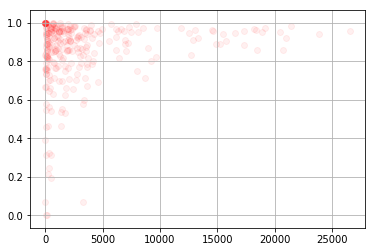

In [133]:
import matplotlib.pyplot as plt
from sod.evaluation import is_outlier
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

plt.scatter(stats_df['segments'], stats_df['correctly_predicted'], color='#FF00000F')
#plt.xlim(0, 5000)
plt.grid(True)

In [141]:
# (n over k)(p^k)*(1-p)^(n-k)

from scipy.stats import binom

prob = 0
k = 2

stats_df2 = stats_df[stats_df['correctly_predicted']<0.5]
print(stats_df2)
stats_df2 = stats_df[stats_df['correctly_predicted'] >= 0.5]


ccs = 100* (np.true_divide(len(stats_df2), len(stats_df)))

for k in [1, 3, 501, 1001, 5001]:
    min_req_k = int(np.true_divide(k, 2))
    prob = 1
    for p, n in zip(stats_df2['correctly_predicted'], stats_df2['segments']):
        prob *= binom.sf(min_req_k, k, p, loc=0)
#         if n <= min_req_k:
#             continue
#         prob_ = binom.sf(min_req_k, n, p, loc=0)
#         if (prob_ == 1):
#             print([min_req_k, n, p])
#             raise
        # print(1-prob_)
        # prob *= 1.0 - prob_
#         print([1.0 - prob_, prob])
    print('Probability to correctly classify %.2f%% of stations by randomly picking %d segments' % (ccs, k))
    print(prob)

     correctly_predicted  segments  station_id
0               0.192982       513         512
3               0.465217       230         676
19              0.312500        48         960
32              0.388889        18        2423
40              0.212560       207        2447
82              0.311828       465        3633
116             0.000000        54        3780
157             0.465339      1356        4287
173             0.325137       366        4568
186             0.068258      3267        4762
204             0.066667        15        5224
246             0.247788       339        5860
247             0.000000       150        5861
264             0.460317        63       10161
Probability to correctly classify 95.04% of stations by randomly picking 1 segments
1.3445896645621357e-16
Probability to correctly classify 95.04% of stations by randomly picking 3 segments
4.579480359200788e-09
Probability to correctly classify 95.04% of stations by randomly picking 501 segme

In [91]:
predictions_ = predictions[is_out_wrong_inv(predictions)]

sta_df_o = []
for sta_id, df in dataframe[is_out_wrong_inv(dataframe)].groupby(['station_id']):
    pred_df = predictions_[predictions.id.isin(pd.unique(df.id))]
    # print('sta_id : %d, ccc: %d, tot: %d' % (sta_id, pred_df.correctly_predicted.sum(), len(pred_df)))
    sta_df_o.append({
        'station_id': sta_id,
        'correctly_predicted': np.true_divide(pred_df.correctly_predicted.sum(), len(pred_df)),
        'segments': len(pred_df)
    })
    # staid, segid = df.iloc[0].station_id, df.iloc[0].id
    # predictions.loc[predictions.id == segid, 'station_id'] = staid

stats_df_o = pd.DataFrame(sta_df_o)
print(stats_df_o.to_string())

/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


   correctly_predicted  segments  station_id
0             0.993464      1989         890
1             1.000000         9        5831
2             1.000000      2232        5833
3             1.000000        27       10179
4             1.000000        90       10186


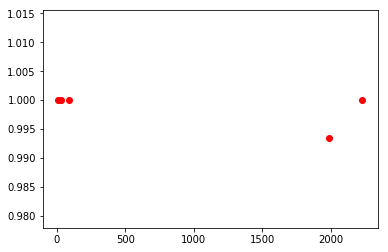

In [93]:
plt.scatter(stats_df_o['segments'], stats_df_o['correctly_predicted'], color='#FF0000FF')  # with delta_pgv does not change a lot